In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+555.g9b2e71684.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.19 GB available memory.


In [6]:
from desc.particles import *
from diffrax import *
from desc.plotting import sequential_colors

In [19]:
name = "ncsx"
try:
    # if the file exists, load it
    eq = desc.io.load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 3878
Number of objectives: 9500

Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied. (ftol=1.00e-04)
         Current function value: 4.171e-07
         Total delta_x: 3.333e-01
         Iterations: 21
         Function evaluations: 22
         Jacobian evaluations: 22
                                                                 Start  -->   End
Total (sum of squares):                                      1.958e-02  -->   4.171e-07, 
Maximum absolute Force error:     

In [71]:
xis = np.array([0.01, 0.2, 0.5])
rho = 0.4
# xis = 0.5
# rho = 0.4
colors = [
    "#c80016",  # red
    # "#dc5b0e",  # burnt orange
    # "#f0b528",  # light orange
    # "#dce953",  # yellow
    "#0f5c10",  # green
    # "#1fb7c9",  # teal
    # "#2192e3",  # medium blue
    # "#4f66d4",  # blue-violet
    "#9a45db",  # purple
]
particles = ManualParticleInitializerFlux(
    rho0=rho, theta0=0, zeta0=0.0, xi0=xis, E=3.5e6
)
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = np.linspace(0, 7e-5, 2000)

In [72]:
fig = plot_3d(
    eq,
    "|B|",
    alpha=0.2,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    showscale=False,
)
fig, data = plot_particle_trajectories(
    eq,
    model,
    particles,
    ts=ts,
    fig=fig,
    rtol=1e-5, 
    atol=1e-5, 
    min_step_size=1e-8,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    return_data=True,
    color=colors,
)
fig

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 3.



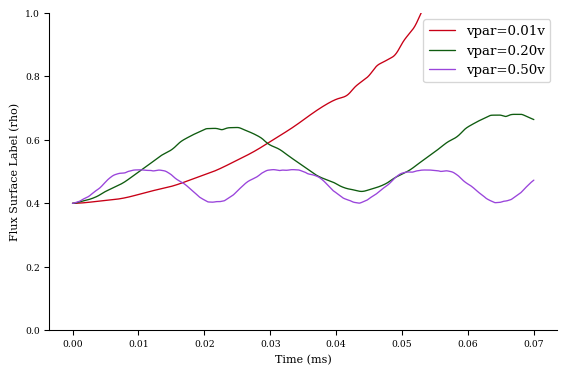

In [76]:
for idx in range(len(data["rho"])):
    plt.plot(
        ts*1000,
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.xlabel("Time (ms)")
plt.ylabel("Flux Surface Label (rho)")
plt.ylim([0, 1])
plt.legend()
plt.savefig("rho-time-ncsx.png", dpi=500)

In [ ]:
def fit_line(y):
    # replace nans with zeros, since (0,0) is already the initial
    # point, this will not affect the fit
    y = jnp.where(jnp.isnan(y), 0.0, y)
    ts0 = jnp.where(jnp.isnan(y), 0.0, ts)
    coeffs = jnp.polyfit(ts0, y, 1)
    return coeffs

for idx in range(len(data["rho"])):
    plt.plot(
        ts * 1000,
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
    coeffs = fit_line(data["rho"][idx])
    plt.plot(
        ts * 1000,
        (coeffs[0]*ts + coeffs[1]),
        "--",
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v line fit",
    )
plt.xlabel("Time (ms)")
plt.ylabel("Flux Surface Label (rho)")
plt.ylim([0, 1])
plt.legend()
plt.savefig("W7-X-particle-line-fit.png", dpi=500)

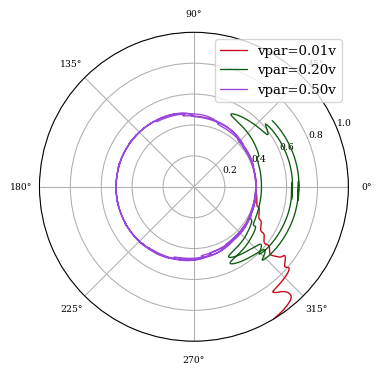

In [77]:
for idx in range(len(data["rho"])):
    plt.polar(
        data["theta"][idx],
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.ylim([0, 1])
plt.legend()
plt.savefig("ncsx-particle-polar.png", dpi=500)